In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 1208
CONVERGENCE_THRESHOLD = 1e-3
N_MIXTURES_TO_FIT = 100

In [3]:
from bernoullimix import BernoulliMixture, random_mixture_generator

In [4]:
import sklearn.datasets
digits_dataset = sklearn.datasets.load_digits()
digits = pd.DataFrame(digits_dataset.data)
labels = pd.Series(digits_dataset.target, index=digits.index)


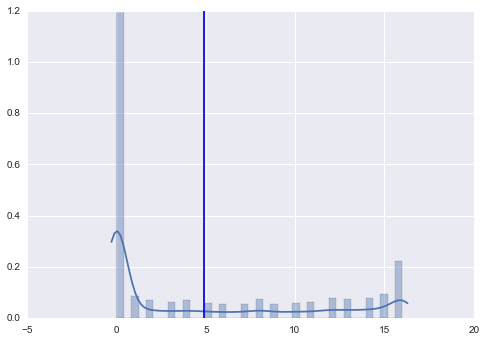

In [5]:
THRESHOLD = np.mean(digits.values.reshape(-1))
sns.distplot(digits.values.reshape(-1))
plt.axvline(THRESHOLD)

In [6]:
binary_digits = digits >= THRESHOLD

In [7]:
from sklearn.utils import shuffle
binary_digits = shuffle(binary_digits, random_state=RANDOM_STATE)
labels = labels.loc[binary_digits.index]

In [8]:
K=len(labels.unique())
D=len(binary_digits.columns)

In [9]:
def draw_digit(row, vmin=0, vmax=1, square=True, **kwargs):
    return sns.heatmap(row.astype(float).reshape(8, 8), square=square, vmin=vmin, vmax=vmax, **kwargs)

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


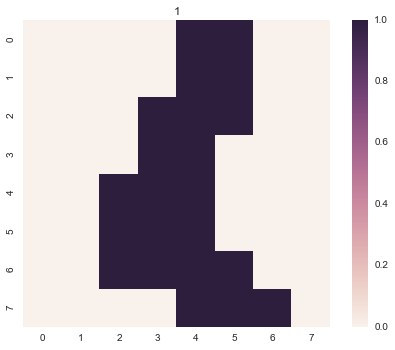

In [11]:
draw_digit(binary_digits.iloc[0])
plt.title(labels.iloc[0])

In [12]:
def plot_true_components(dataset, labels, **kwargs):
    
    ratios = labels.value_counts() / len(labels)
    
    plt.figure(figsize=(15,15))
    for i, (ix, ratio) in enumerate(ratios.iteritems()):
        ax = plt.subplot(4, 3, i+1)
        subdataset = dataset[labels==ix]
        draw_digit(subdataset.mean(), ax=ax)
        plt.title('{} ({:.2%})'.format(ix, ratio))

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


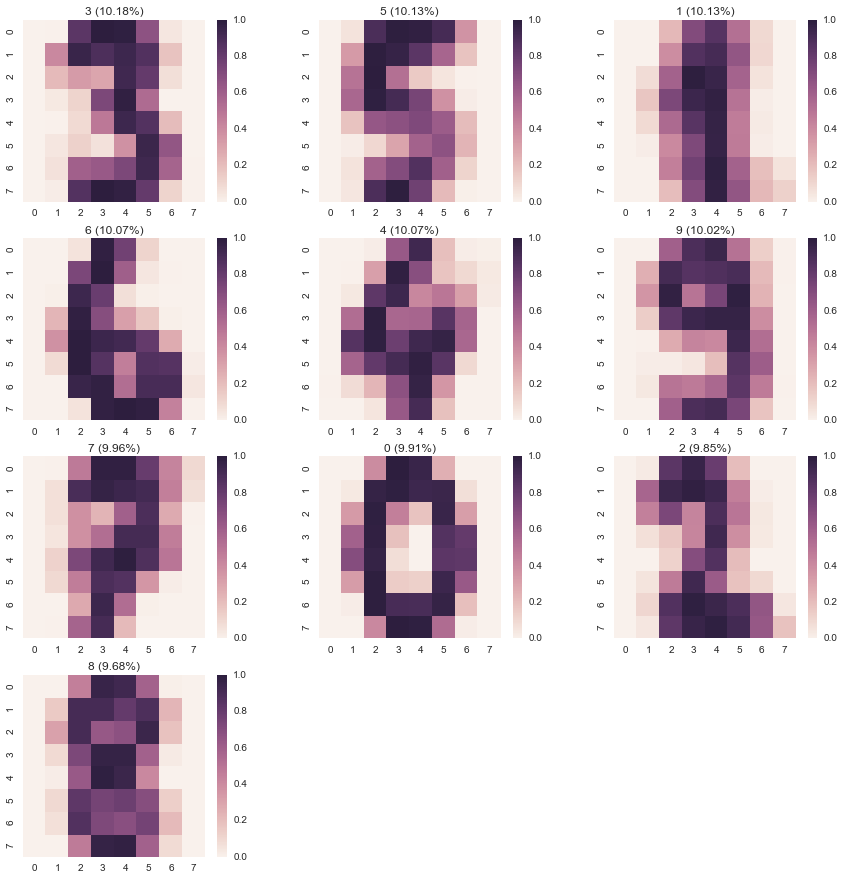

In [13]:
plot_true_components(binary_digits, labels)

In [14]:
import itertools
def fit_mixtures(dataset, n_mixtures=N_MIXTURES_TO_FIT, k=K, random_state=RANDOM_STATE, 
                 convergence_threshold=CONVERGENCE_THRESHOLD):
    generator = random_mixture_generator(k, dataset, random_state=RANDOM_STATE)
    mixtures = list(itertools.islice(generator, n_mixtures))
    
    bics = []
    for mixture in mixtures:
        ll, converged = mixture.fit(dataset, iteration_limit=None, convergence_threshold=convergence_threshold)
        bics.append(mixture.BIC(ll, number_of_observations=len(dataset)))
    
    return mixtures, mixtures[np.argmin(bics)]


In [15]:
%%time
__, best_full_data = fit_mixtures(binary_digits)

CPU times: user 2min 4s, sys: 274 ms, total: 2min 5s
Wall time: 2min 5s


In [16]:
best_full_data

In [17]:
def plot_emission_probabilities(mixture, figsize=(15,15), **kwargs):
    
    mcs = pd.Series(mixture.mixing_coefficients)
    eps = pd.DataFrame(mixture.emission_probabilities, index=mcs.index)
    
    mcs = mcs.sort_values(ascending=False)
    eps = eps.loc[mcs.index]
    
    plt.figure(figsize=figsize)
    for i, (ix, mc) in enumerate(mcs.iteritems()):
        ax = plt.subplot(4, 3, i+1)
        draw_digit(eps.loc[ix], ax=ax, **kwargs)
        plt.title('Component {} ({:.2%})'.format(ix, mc))
        

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


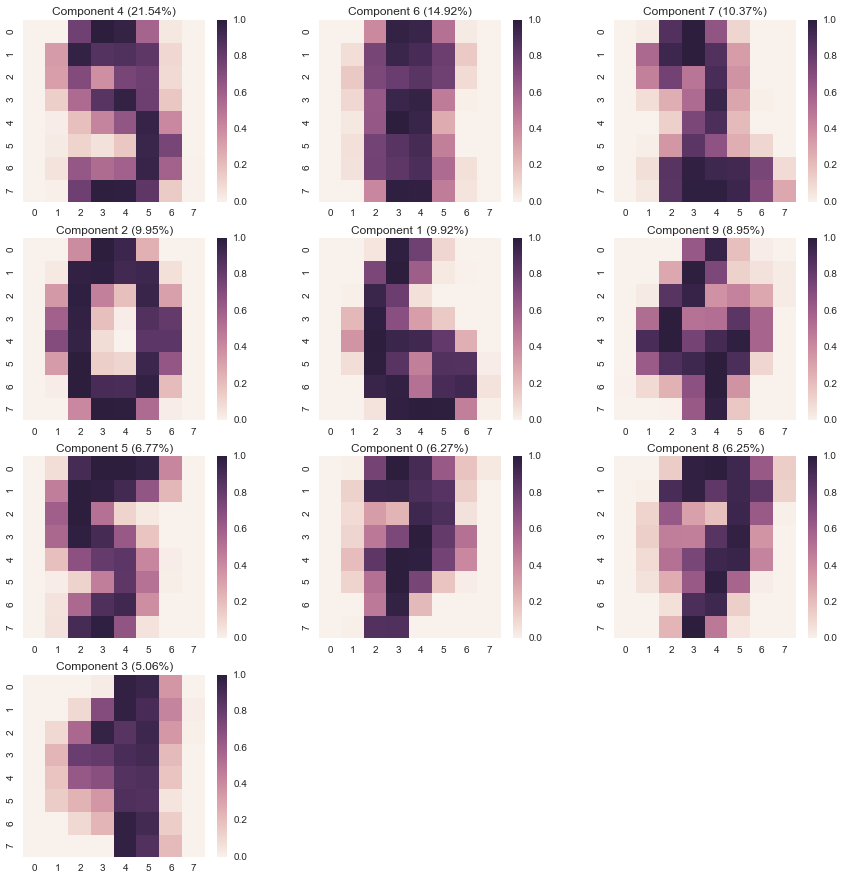

In [18]:
plot_emission_probabilities(best_full_data)

# Missing Data Dataset

In [19]:
up_missing = binary_digits.iloc[:len(binary_digits)//4].copy()
bottom_missing = binary_digits.iloc[len(binary_digits)//4:len(binary_digits)//2].copy()
even_missing = binary_digits.iloc[len(binary_digits)//2:].copy()

In [20]:
up_missing.iloc[:, :D//2] = None
bottom_missing.iloc[:, D//2:] = None
even_missing.iloc[:, np.arange(0, D, 2)] = None

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


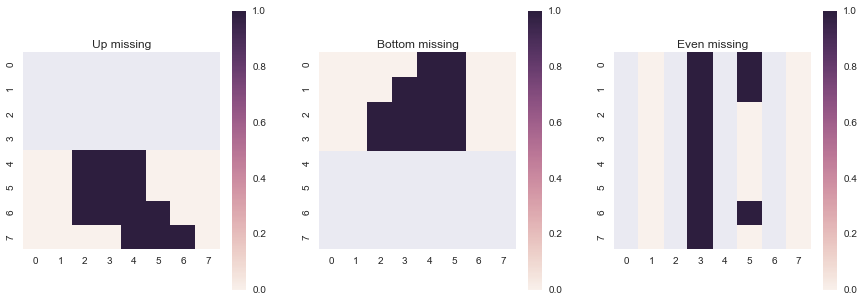

In [21]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
draw_digit(up_missing.iloc[0], ax=ax)
plt.title('Up missing')
ax = plt.subplot(1, 3, 2)
draw_digit(bottom_missing.iloc[0], ax=ax)
plt.title('Bottom missing')
ax = plt.subplot(1, 3, 3)
draw_digit(even_missing.iloc[0], ax=ax)
plt.title('Even missing')

In [22]:
binary_digits_with_noise = pd.concat((up_missing, bottom_missing, even_missing))

In [23]:
binary_digits_with_noise.shape

(1797, 64)

In [24]:
__, best_noise = fit_mixtures(binary_digits_with_noise)

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


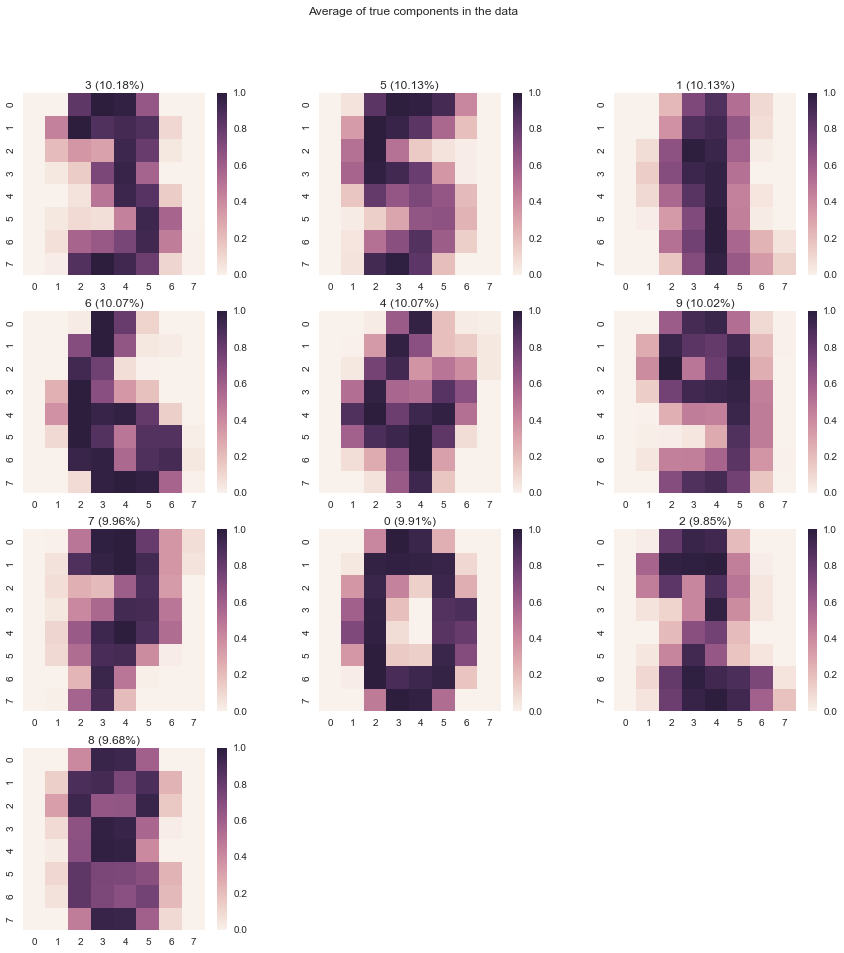

In [25]:
plot_true_components(binary_digits_with_noise, labels)
plt.suptitle('Average of true components in the data')

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


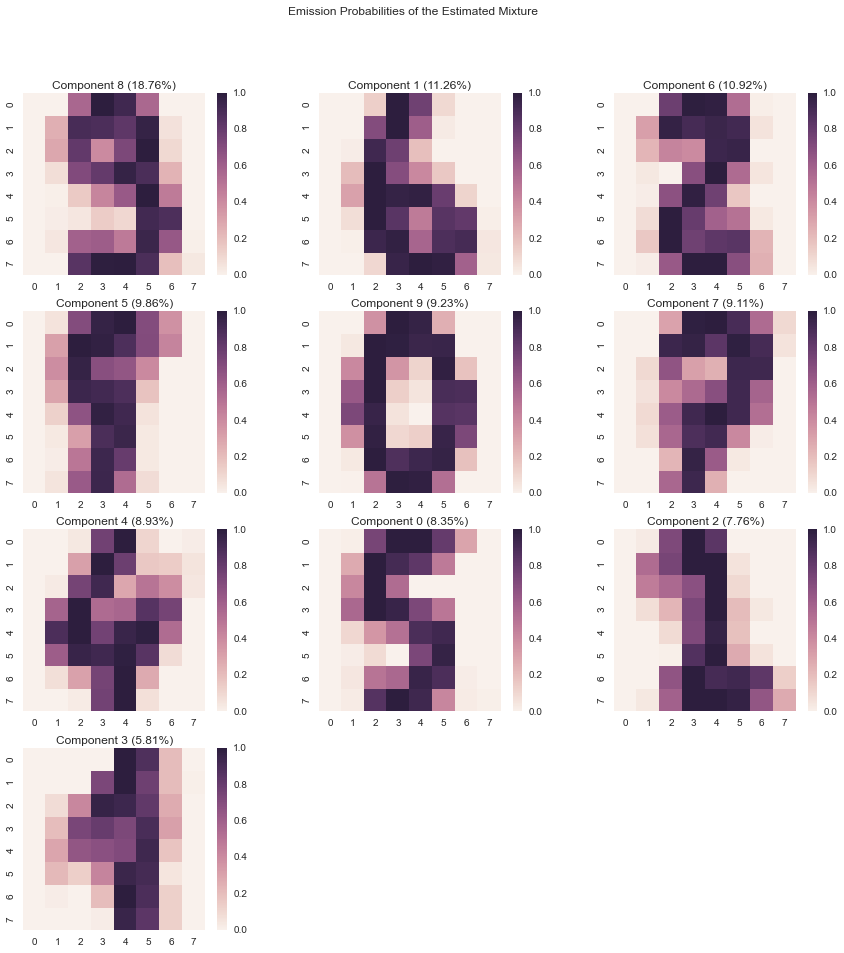

In [26]:
plot_emission_probabilities(best_noise)
plt.suptitle('Emission Probabilities of the Estimated Mixture')

In [27]:
imputed_dataset = best_noise.impute_missing_values(binary_digits_with_noise)

In [28]:
def draw_imputed_vs_true(index):
    
    plt.figure(figsize=(15, 5))
    
    imputed_row = imputed_dataset.loc[index]
    true_row = binary_digits.loc[index]
    true_nonbinary_row = digits.loc[index]
    
    ax = plt.subplot(1, 3, 1)
    draw_digit(imputed_row, ax=ax)
    plt.title('Imputed')
    ax = plt.subplot(1, 3, 2)
    draw_digit(true_row, ax=ax)
    plt.title('True ({})'.format(labels.loc[index]))
    ax = plt.subplot(1, 3, 3)
    draw_digit(true_nonbinary_row, ax=ax, vmin=0, vmax=None)
    plt.title('True (non-binarised)')

/Users/saulius/.virtualenvs/scientific-py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


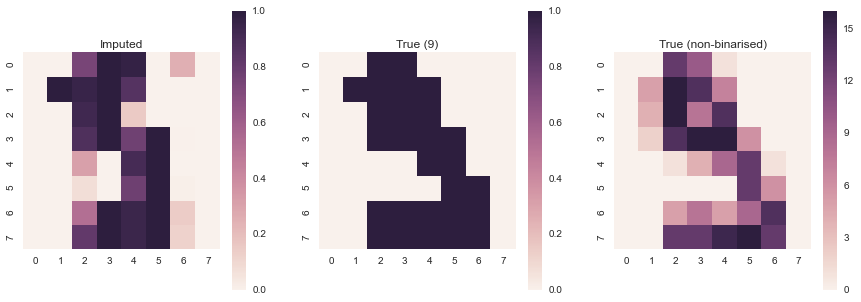

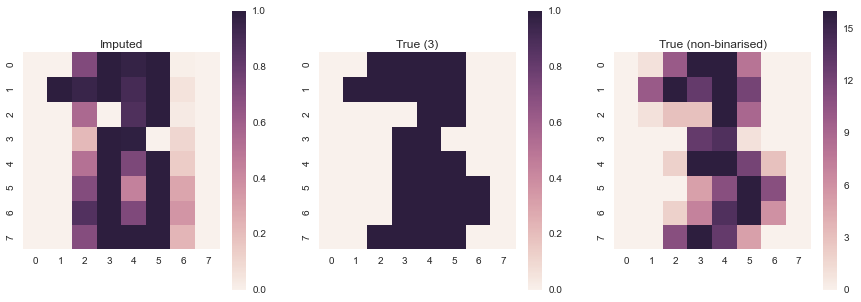

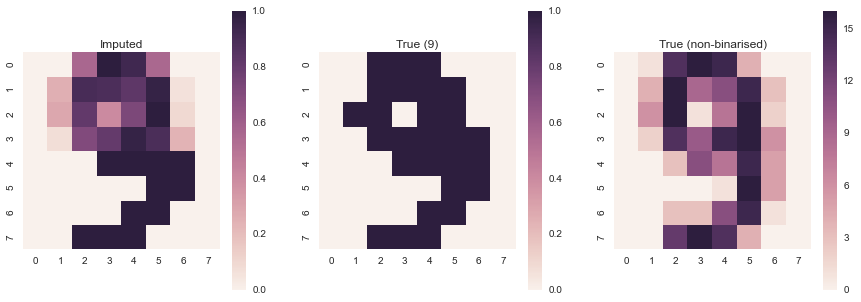

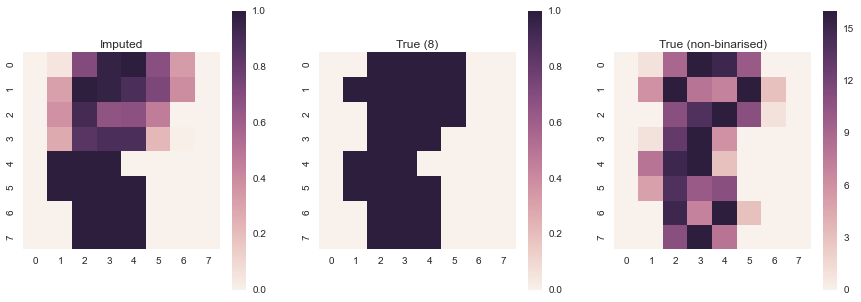

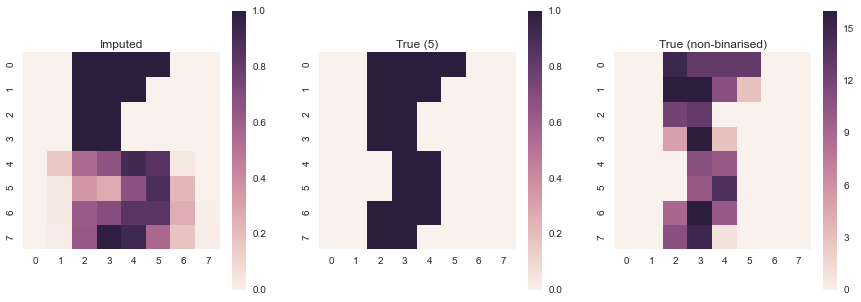

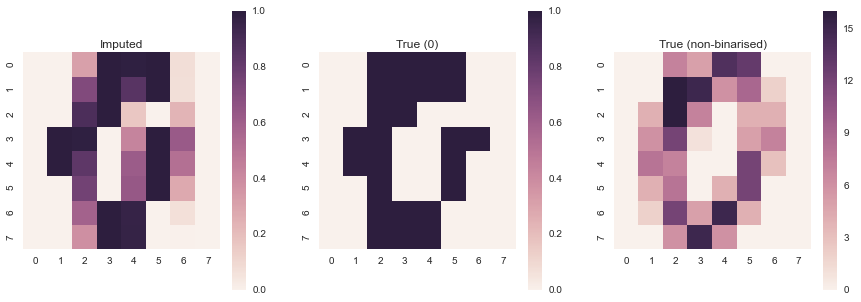

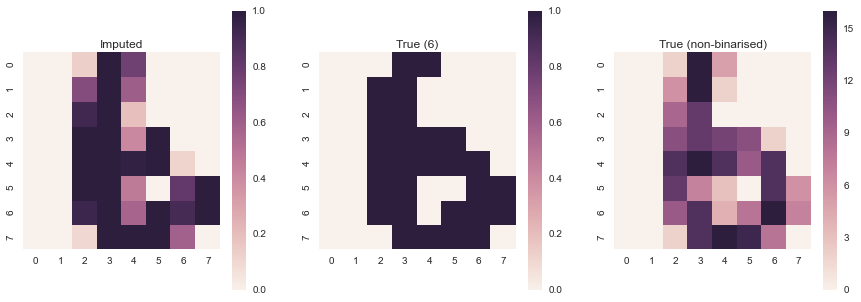

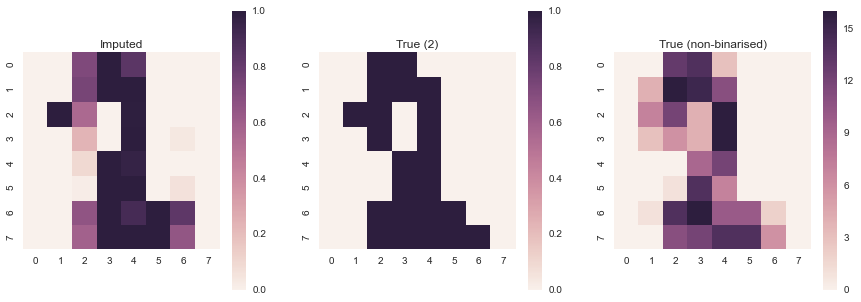

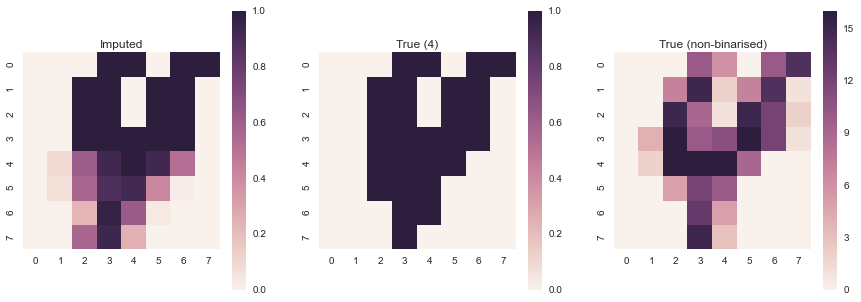

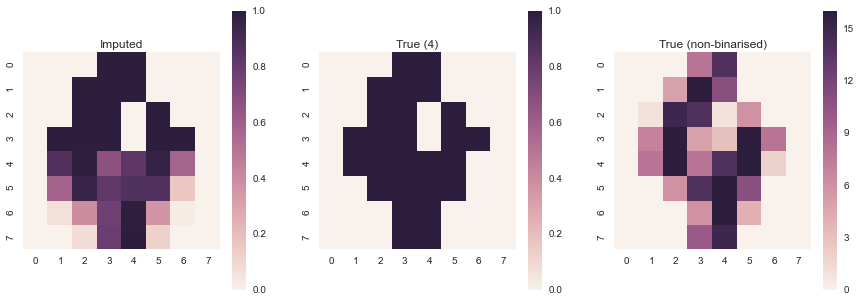

In [29]:
n_random = 10
random_sample = imputed_dataset.sample(n_random).index

for ix in random_sample:
    draw_imputed_vs_true(ix)

## 